<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### импорт библиотек

In [1]:
!pip install -U accelerate
!pip install -U transformers
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.28.0
    Uninstalling accelerate-0.28.0:
      Successfully uninstalled accelerate-0.28.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.ticker as ticker
from transformers import get_scheduler
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import Trainer, TrainingArguments
from datasets import load_metric
import evaluate

import numpy as np
import pandas as pd

import random
import math
import time
import string
# import pymorphy2
import re

# datasets from huggingface
# from datasets import load_dataset
from transformers import BertTokenizer, BertModel

from nltk.corpus import stopwords
import nltk

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import os
from datetime import datetime
from torch.nn.utils.rnn import pad_sequence

from datasets import load_dataset, load_metric

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

2024-04-14 11:54:50.497869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 11:54:50.497968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 11:54:50.611351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


device(type='cuda')

In [44]:
import warnings
warnings.filterwarnings('always') 

###  Загрузка данных

In [ ]:
df = pd.read_csv('/content/df_tasks.csv',  usecols=['Задача', 'Тема'])
# df = pd.read_csv('/content/df_tasks.csv')

df

Задача     Тема
0     Между девятью планетами Солнечной системы введ...    Графы
1     В стране Цифра есть 9 городов с названиями 1, ...    Графы
2     В государстве 100 городов, и из каждого из них...    Графы
3     В классе 30 человек. Может ли быть так, что 9 ...    Графы
4     В городе Маленьком 15 телефонов. Можно ли их с...    Графы
...                                                 ...      ...
5268  Дьявол предлагает Человеку сыграть в следующую...  Дирихле
5269  По шоссе в одном направлении едут 10 автомобил...  Дирихле
5270  В пространстве имеются 30 ненулевых векторов. ...  Дирихле
5271  На плоскости даны две точки A и B. Пусть C – н...  Дирихле
5272  На плоскости нарисованы неравнобедренный треуг...  Дирихле

[5273 rows x 2 columns]

In [ ]:
df.isna().value_counts() # проверка на пропуски
# пропусков нет

Задача  Тема 
False   False    5273
Name: count, dtype: int64

In [ ]:
df['Тема'].value_counts()
# 7 классов

Тема
Теория чисел     2396
Комбинаторика    1020
Дирихле           441
Многочлен         426
Графы             384
Геометрия         371
Инвариант         235
Name: count, dtype: int64

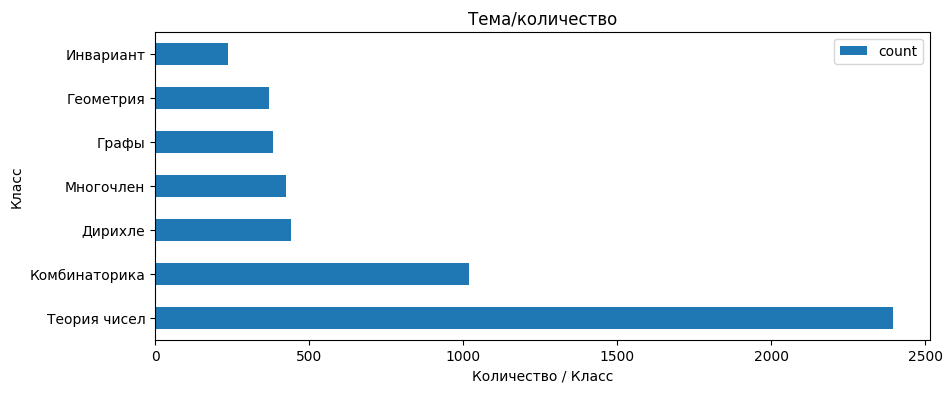

In [ ]:
# проверим распределение классов и сбалансированность датасета
# функция создает датасет с распределением классов
from collections import Counter
def loads_labels(dataset):
    labels = []
    for i in dataset:
        labels.append(i)
    counts = Counter(labels)
    count_df =  pd.DataFrame([(k, v) for k, v in counts.items()],
    columns=['cls', 'count'])
    return count_df.sort_values(by = 'count', ascending = False)

df_balance = loads_labels(df['Тема'].values)
df_balance.reset_index()

ax = df_balance.plot.barh(x='cls', y='count', rot=0, figsize = (10,4), title='Тема/количество',
                     xlabel='Количество / Класс',
                     ylabel='Класс')

Выраженный дисбаланс классов

In [ ]:
# Подсчет кол-ва слов, кол-ва символов, длин текстов
df1 = df.copy()
# количество слов в задачах для каждого таргета
df1['len_text_words'] = df1['Задача'].astype('str').apply(lambda text : len(text.split()))
# количество символов без пробелов в задачах для каждого таргета
df1['len_text_symbols'] =  df1['Задача'].astype('str').apply(lambda text : len(text.replace(' ', '')))
# количество символов в задачах для каждого таргета
df1['length_posts'] = df1['Задача'].astype('str').apply(len)
df1

Задача     Тема  \
0     Между девятью планетами Солнечной системы введ...    Графы   
1     В стране Цифра есть 9 городов с названиями 1, ...    Графы   
2     В государстве 100 городов, и из каждого из них...    Графы   
3     В классе 30 человек. Может ли быть так, что 9 ...    Графы   
4     В городе Маленьком 15 телефонов. Можно ли их с...    Графы   
...                                                 ...      ...   
5268  Дьявол предлагает Человеку сыграть в следующую...  Дирихле   
5269  По шоссе в одном направлении едут 10 автомобил...  Дирихле   
5270  В пространстве имеются 30 ненулевых векторов. ...  Дирихле   
5271  На плоскости даны две точки A и B. Пусть C – н...  Дирихле   
5272  На плоскости нарисованы неравнобедренный треуг...  Дирихле   

      len_text_words  len_text_symbols  length_posts  
0                 51               264           316  
1                 51               233           284  
2                 17                83            99  
3                 30                94           123  
4                 40               217           256  
...              ...               ...           ...  
5268              57               335           392  
5269              74               461           535  
5270              17               101           116  
5271              65               324           391  
5272              40               213           253  

[5273 rows x 5 columns]

len_text_words  len_text_symbols  length_posts
count     5273.000000       5273.000000   5273.000000
mean        44.772426        272.665276    314.987104
std         52.000366        445.418540    485.473432
min          0.000000          0.000000      1.000000
25%         20.000000         99.000000    120.000000
50%         32.000000        165.000000    197.000000
75%         48.000000        256.000000    304.000000
max        491.000000       4171.000000   4489.000000

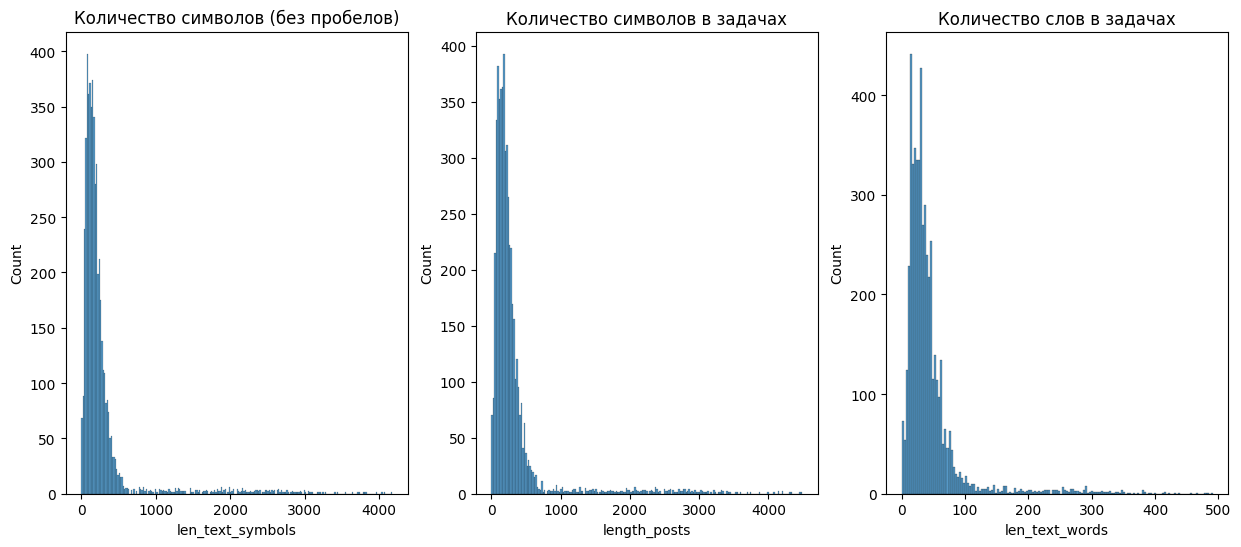

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
sns.histplot(df1["len_text_symbols"]).set_title("Количество символов (без пробелов)")

plt.subplot(1, 3, 2)
sns.histplot(df1["length_posts"]).set_title("Количество символов в задачах")

plt.subplot(1, 3, 3)
sns.histplot(df1["len_text_words"]).set_title("Количество слов в задачах");

df1.describe()

### Препроцессинг текста

In [ ]:
# Очистка текстов
def clear(data):
    # удаление ссылок
    df["Задача"] = df["Задача"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    # удаление пунктуационных знаков
    df["Задача"] = df["Задача"].apply(lambda x: re.sub(r'\W+', " ", x))
    # df["Задача"] = df["Задача"].apply(lambda x: re.sub(r'\А\'', " ", x))
    # df["Задача"] = df["Задача"].apply(lambda x: re.sub(r'\'\Я', " ", x))
    #удаление повторяющихся пробелов
    df["Задача"] = df["Задача"].apply(lambda x: re.sub(r'\s{2,}', ' ' ,x))
    df["Задача"] = df["Задача"].apply(lambda x: re.sub(r'\А\s', '', x))
    #перевод в нижний регистр
    df["Задача"] = df["Задача"].apply(lambda x: x.lower())
    # добавление токена начала [CLS]
    # df["Задача"] = df["Задача"].apply(lambda x: f"[CLS] {''.join(x)}")
    return df

In [ ]:
cleared_df = clear(df)
cleared_df

Задача     Тема
0     между девятью планетами солнечной системы введ...    Графы
1     в стране цифра есть 9 городов с названиями 1 2...    Графы
2     в государстве 100 городов и из каждого из них ...    Графы
3     в классе 30 человек может ли быть так что 9 из...    Графы
4     в городе маленьком 15 телефонов можно ли их со...    Графы
...                                                 ...      ...
5268  дьявол предлагает человеку сыграть в следующую...  Дирихле
5269  по шоссе в одном направлении едут 10 автомобил...  Дирихле
5270  в пространстве имеются 30 ненулевых векторов д...  Дирихле
5271  на плоскости даны две точки a и b пусть c неко...  Дирихле
5272  на плоскости нарисованы неравнобедренный треуг...  Дирихле

[5273 rows x 2 columns]

In [ ]:
cleared_df['Задача'][0]

'между девятью планетами солнечной системы введено космическое сообщение ракеты летают по следующим маршрутам земля меркурий плутон венера земля плутон плутон меркурий меркурий венера уран нептун нептун сатурн сатурн юпитер юпитер марс и марс уран можно ли добраться с земли до марса '

In [ ]:
# количество слов в задачах для каждого таргета
df1['Задача_'] = cleared_df['Задача']
df1['len_text_words_'] = cleared_df['Задача'].astype('str').apply(lambda text : len(text.split()))
# количество символов без пробелов в задачах для каждого таргета
df1['len_text_symbols_'] =  cleared_df['Задача'].astype('str').apply(lambda text : len(text.replace(' ', '')))
# количество символов в задачах для каждого таргета
df1['length_posts_'] = cleared_df['Задача'].astype('str').apply(len)

In [ ]:
df1['Задача'][1]

'В стране Цифра есть 9 городов с названиями 1, 2, 3, 4, 5, 6, 7, 8, 9. Путешественник обнаружил, что два города соединены авиалинией в том и только в том случае, если двузначное число, составленное из цифр-названий этих городов, делится на 3. Можно ли добраться из города 1 в город 9? '

In [ ]:
df1['Задача_'][1]

'в стране цифра есть 9 городов с названиями 1 2 3 4 5 6 7 8 9 путешественник обнаружил что два города соединены авиалинией в том и только в том случае если двузначное число составленное из цифр названий этих городов делится на 3 можно ли добраться из города 1 в город 9 '

In [ ]:
# кодирование таргета - Темы
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# кодировка классов
le.fit(df1['Тема'])
df1['label'] = le.transform(df1['Тема'])
df1

Задача     Тема  \
0     Между девятью планетами Солнечной системы введ...    Графы   
1     В стране Цифра есть 9 городов с названиями 1, ...    Графы   
2     В государстве 100 городов, и из каждого из них...    Графы   
3     В классе 30 человек. Может ли быть так, что 9 ...    Графы   
4     В городе Маленьком 15 телефонов. Можно ли их с...    Графы   
...                                                 ...      ...   
5268  Дьявол предлагает Человеку сыграть в следующую...  Дирихле   
5269  По шоссе в одном направлении едут 10 автомобил...  Дирихле   
5270  В пространстве имеются 30 ненулевых векторов. ...  Дирихле   
5271  На плоскости даны две точки A и B. Пусть C – н...  Дирихле   
5272  На плоскости нарисованы неравнобедренный треуг...  Дирихле   

      len_text_words  len_text_symbols  length_posts  \
0                 51               264           316   
1                 51               233           284   
2                 17                83            99   
3                 30                94           123   
4                 40               217           256   
...              ...               ...           ...   
5268              57               335           392   
5269              74               461           535   
5270              17               101           116   
5271              65               324           391   
5272              40               213           253   

                                                Задача_  len_text_words_  \
0     между девятью планетами солнечной системы введ...               41   
1     в стране цифра есть 9 городов с названиями 1 2...               52   
2     в государстве 100 городов и из каждого из них ...               17   
3     в классе 30 человек может ли быть так что 9 из...               28   
4     в городе маленьком 15 телефонов можно ли их со...               40   
...                                                 ...              ...   
5268  дьявол предлагает человеку сыграть в следующую...               58   
5269  по шоссе в одном направлении едут 10 автомобил...               75   
5270  в пространстве имеются 30 ненулевых векторов д...               17   
5271  на плоскости даны две точки a и b пусть c неко...               63   
5272  на плоскости нарисованы неравнобедренный треуг...               43   

      len_text_symbols_  length_posts_  label  
0                   242            283      1  
1                   217            269      1  
2                    80             97      1  
3                    85            113      1  
4                   209            249      1  
...                 ...            ...    ...  
5268                313            371      2  
5269                448            523      2  
5270                 94            111      2  
5271                294            357      2  
5272                194            237      2  

[5273 rows x 10 columns]

In [ ]:
set(df1.label)

{0, 1, 2, 3, 4, 5, 6}

In [ ]:
# удаление строк с текстом задачи меньше 2 слов
df1 = df1.loc[((df1['len_text_words_'] > 2))]
df1

Задача     Тема  \
0     Между девятью планетами Солнечной системы введ...    Графы   
1     В стране Цифра есть 9 городов с названиями 1, ...    Графы   
2     В государстве 100 городов, и из каждого из них...    Графы   
3     В классе 30 человек. Может ли быть так, что 9 ...    Графы   
4     В городе Маленьком 15 телефонов. Можно ли их с...    Графы   
...                                                 ...      ...   
5268  Дьявол предлагает Человеку сыграть в следующую...  Дирихле   
5269  По шоссе в одном направлении едут 10 автомобил...  Дирихле   
5270  В пространстве имеются 30 ненулевых векторов. ...  Дирихле   
5271  На плоскости даны две точки A и B. Пусть C – н...  Дирихле   
5272  На плоскости нарисованы неравнобедренный треуг...  Дирихле   

      len_text_words  len_text_symbols  length_posts  \
0                 51               264           316   
1                 51               233           284   
2                 17                83            99   
3                 30                94           123   
4                 40               217           256   
...              ...               ...           ...   
5268              57               335           392   
5269              74               461           535   
5270              17               101           116   
5271              65               324           391   
5272              40               213           253   

                                                Задача_  len_text_words_  \
0     между девятью планетами солнечной системы введ...               41   
1     в стране цифра есть 9 городов с названиями 1 2...               52   
2     в государстве 100 городов и из каждого из них ...               17   
3     в классе 30 человек может ли быть так что 9 из...               28   
4     в городе маленьком 15 телефонов можно ли их со...               40   
...                                                 ...              ...   
5268  дьявол предлагает человеку сыграть в следующую...               58   
5269  по шоссе в одном направлении едут 10 автомобил...               75   
5270  в пространстве имеются 30 ненулевых векторов д...               17   
5271  на плоскости даны две точки a и b пусть c неко...               63   
5272  на плоскости нарисованы неравнобедренный треуг...               43   

      len_text_symbols_  length_posts_  label  
0                   242            283      1  
1                   217            269      1  
2                    80             97      1  
3                    85            113      1  
4                   209            249      1  
...                 ...            ...    ...  
5268                313            371      2  
5269                448            523      2  
5270                 94            111      2  
5271                294            357      2  
5272                194            237      2  

[5209 rows x 10 columns]

In [ ]:
df1.loc[((df1['len_text_words_'] > 400))]

Задача          Тема  \
295   На олимпиаду пришло 2018 участников, некоторые...         Графы   
526   \nНа продолжении хорды KL окружности с центром...     Геометрия   
4306  В белой таблице 2016×2016 некоторые клетки окр...  Теория чисел   
4498  Есть шоколадка в форме равностороннего треугол...  Теория чисел   
4568     а) Скупой рыцарь хранит золотые монеты в ше...  Теория чисел   
4781  На доске 4×6 клеток стоят две чёрные фишки (Ва...     Инвариант   

      len_text_words  len_text_symbols  length_posts  \
295              467              3829          4204   
526              456              3956          4311   
4306             481              3736          4141   
4498             431              3715          4074   
4568             482              4071          4453   
4781             491              3788          4201   

                                                Задача_  len_text_words_  \
295   на олимпиаду пришло 2018 участников некоторые ...              449   
526    на продолжении хорды kl окружности с центром ...              414   
4306  в белой таблице 2016 2016 некоторые клетки окр...              450   
4498  есть шоколадка в форме равностороннего треугол...              403   
4568   а скупой рыцарь хранит золотые монеты в шести...              441   
4781  на доске 4 6 клеток стоят две чёрные фишки ван...              480   

      len_text_symbols_  length_posts_  label  
295                2341           2790      1  
526                2178           2593      0  
4306               2363           2813      6  
4498               2182           2585      6  
4568               2253           2695      6  
4781               2353           2833      3

len_text_words  len_text_symbols  length_posts  len_text_words_  \
count     5209.000000       5209.000000   5209.000000      5209.000000   
mean        45.306585        275.927817    318.732770        43.703974   
std         52.093594        447.166732    487.261715        48.909317   
min          3.000000          8.000000     14.000000         3.000000   
25%         21.000000        102.000000    124.000000        20.000000   
50%         32.000000        167.000000    199.000000        31.000000   
75%         49.000000        258.000000    305.000000        48.000000   
max        491.000000       4171.000000   4489.000000       480.000000   

       len_text_symbols_  length_posts_        label  
count        5209.000000    5209.000000  5209.000000  
mean          217.086197     260.861586     4.275101  
std           251.251650     299.890857     2.003203  
min             3.000000       7.000000     0.000000  
25%            91.000000     112.000000     3.000000  
50%           153.000000     183.000000     5.000000  
75%           241.000000     289.000000     6.000000  
max          2363.000000    2833.000000     6.000000

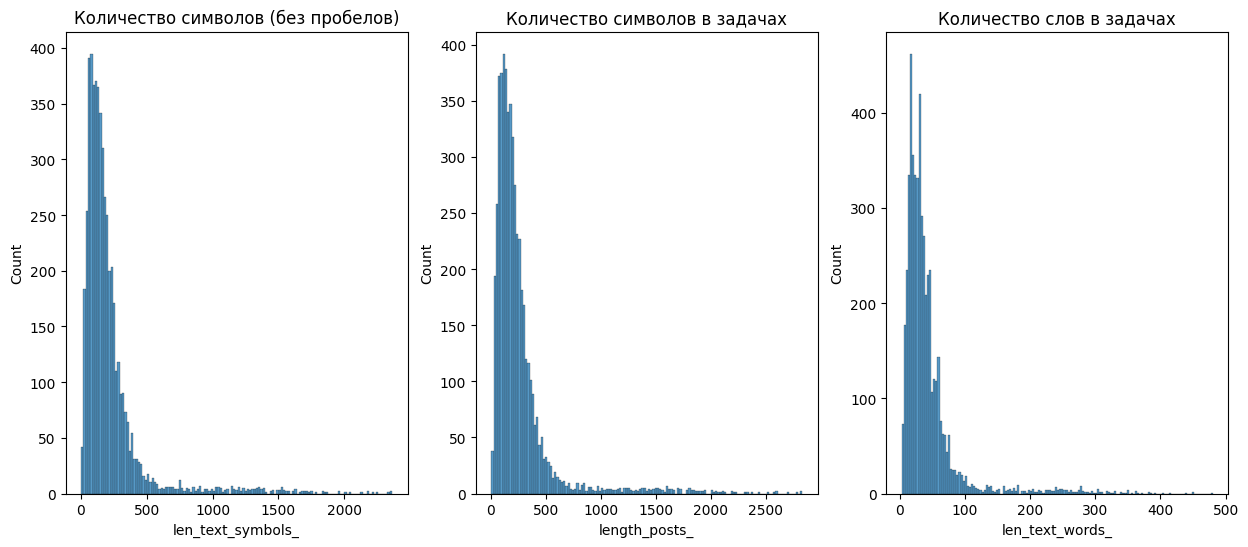

In [ ]:
# распределение длин после препроцессинга
plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
sns.histplot(df1["len_text_symbols_"]).set_title("Количество символов (без пробелов)")

plt.subplot(1, 3, 2)
sns.histplot(df1["length_posts_"]).set_title("Количество символов в задачах")

plt.subplot(1, 3, 3)
sns.histplot(df1["len_text_words_"]).set_title("Количество слов в задачах");

df1.describe()

большинство длин задач состоит неболее, чем из 110 слов и не более, чем 600 символов


In [ ]:
# проверка на дубликаты
df1[df1.duplicated()]

Empty DataFrame
Columns: [Задача, Тема, len_text_words, len_text_symbols, length_posts, Задача_, len_text_words_, len_text_symbols_, length_posts_, label]
Index: []

In [ ]:
df1.describe()

len_text_words  len_text_symbols  length_posts  len_text_words_  \
count     5209.000000       5209.000000   5209.000000      5209.000000   
mean        45.306585        275.927817    318.732770        43.703974   
std         52.093594        447.166732    487.261715        48.909317   
min          3.000000          8.000000     14.000000         3.000000   
25%         21.000000        102.000000    124.000000        20.000000   
50%         32.000000        167.000000    199.000000        31.000000   
75%         49.000000        258.000000    305.000000        48.000000   
max        491.000000       4171.000000   4489.000000       480.000000   

       len_text_symbols_  length_posts_        label  
count        5209.000000    5209.000000  5209.000000  
mean          217.086197     260.861586     4.275101  
std           251.251650     299.890857     2.003203  
min             3.000000       7.000000     0.000000  
25%            91.000000     112.000000     3.000000  
50%           153.000000     183.000000     5.000000  
75%           241.000000     289.000000     6.000000  
max          2363.000000    2833.000000     6.000000

In [ ]:
df2 = pd.DataFrame()
df2['text'] = df1['Задача_'].values
df2['labels'] = df1.label.values
df2

text  labels
0     между девятью планетами солнечной системы введ...       1
1     в стране цифра есть 9 городов с названиями 1 2...       1
2     в государстве 100 городов и из каждого из них ...       1
3     в классе 30 человек может ли быть так что 9 из...       1
4     в городе маленьком 15 телефонов можно ли их со...       1
...                                                 ...     ...
5204  дьявол предлагает человеку сыграть в следующую...       2
5205  по шоссе в одном направлении едут 10 автомобил...       2
5206  в пространстве имеются 30 ненулевых векторов д...       2
5207  на плоскости даны две точки a и b пусть c неко...       2
5208  на плоскости нарисованы неравнобедренный треуг...       2

[5209 rows x 2 columns]

### создание датасета

In [ ]:
# df2.to_csv('df_cleared.csv', index=False)

In [ ]:
# !pip install datasets

In [3]:
full_dataset = load_dataset('csv', data_files='/kaggle/input/cleared-tasks/df_cleared0.csv')
# Фильтрация записей, в которых текстовые поля или метки не являются None
full_dataset = full_dataset.filter(lambda example: example['text'] is not None and example['labels'] is not None)

full_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/5209 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 5209
    })
})

In [4]:
# разделим на обучающую и тестовую
dataset = full_dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4167
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1042
    })
})

In [5]:
# визуализируем один пример
dataset['train'][0]

{'text': 'может ли сумма трёх различных натуральных чисел делиться на каждое из слагаемых ',
 'labels': 6}

In [6]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2")

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
dataset = dataset.map(lambda e:
                      tokenizer(e['text'],
                                truncation = True,
                                max_length=128,
                                padding='max_length'), batched=True)

Map:   0%|          | 0/4167 [00:00<?, ? examples/s]

Map:   0%|          | 0/1042 [00:00<?, ? examples/s]

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4167
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1042
    })
})

In [14]:
# текст был успешно закодирован, более он нам не нужен
dataset = dataset.remove_columns('text')
dataset = dataset.remove_columns('token_type_ids')

In [15]:
# переносим на гпу
dataset.set_format(type='torch')

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4167
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1042
    })
})

In [17]:
dataset['train'][0]

{'labels': tensor(6),
 'input_ids': tensor([    2,  3960, 10632, 32334,  8153,  8509, 58982, 25548, 44736,   548,
         35052,   778, 76524, 12980,     3,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,  

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [18]:
import transformers
from transformers import AutoModelForSequenceClassification
rubert = 'cointegrated/rubert-tiny2'
model_rubert_tiny2 =  AutoModelForSequenceClassification.from_pretrained(rubert, num_labels=7)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model_based.config

#### модель

In [19]:
from typing import Union
### This is just an interface example. You may change it if you want.
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module]):
        super(TransformerClassificationModel, self).__init__()
        self.backbone = base_transformer_model
        self.loss_fn = torch.nn.CrossEntropyLoss()
    # def forward(self, x, labels = True, **inputs):
    def forward(self, input_ids, attention_mask, labels = True):
        # print(x)
        outputs = self.backbone(input_ids = input_ids, attention_mask = attention_mask, token_type_ids=None)
        # print('outputsssss', outputs[0])
        # if attention_mask is None:
        #     attention_mask = torch.ones_like(input_ids)
        if labels is not None:
            loss = self.loss_fn(outputs[0], labels)
        outputs = transformers.modeling_outputs.SequenceClassifierOutput(
            loss = loss,
            logits = outputs[0]
        )
        return outputs

In [20]:
model = TransformerClassificationModel(model_rubert_tiny2)
model.to(device)

TransformerClassificationModel(
  (backbone): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(83828, 312, padding_idx=0)
        (position_embeddings): Embedding(2048, 312)
        (token_type_embeddings): Embedding(2, 312)
        (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-2): 3 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=312, out_features=312, bias=True)
                (key): Linear(in_features=312, out_features=312, bias=True)
                (value): Linear(in_features=312, out_features=312, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=312,

In [21]:
outputs = model(dataset['train']['input_ids'][0].unsqueeze(0).to(device), dataset['train']['attention_mask'][0].unsqueeze(0).to(device), dataset['train']['labels'][0].unsqueeze(0).to(device))
outputs

SequenceClassifierOutput(loss=tensor(1.8980, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0136,  0.0163, -0.0080,  0.0356,  0.0118, -0.0250,  0.0637]],
       device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [23]:
# # тест модели
# for i in range(0, 10):
#     outputs = model(dataset['train']['input_ids'][i].unsqueeze(0).to(device), dataset['train']['attention_mask'][i].unsqueeze(0).to(device), dataset['train']['labels'][i].unsqueeze(0).to(device))
#     print(outputs)


### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [22]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for w in model.backbone.parameters():
        w.requires_grad = False
    for w in model.backbone.classifier.parameters():
        w.requires_grad  = True
    pass
    return model

In [23]:
# функция для отображения обучаемых параметров

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print_trainable_parameters(freeze_backbone_function(model))
count_trainable_params(freeze_backbone_function(model))

trainable params: 2191 || all params: 29195959 || trainable%: 0.007504463203280975


2191

In [42]:
# Загрузка метрики вне функции
metric_f1 = evaluate.load("f1")
metric_accuracy = evaluate.load("accuracy")
clf_metrics = evaluate.combine(["accuracy", "precision", "recall"])

# Параметры обучения
# training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")
# accelerate.DataLoaderConfiguration

training_args = TrainingArguments(
    output_dir="./results",  # Каталог для сохранения результатов обучения
    num_train_epochs=5,  # Количество эпох обучения
    per_device_train_batch_size=8,  # Размер батча для обучения
    per_device_eval_batch_size=8,  # Размер батча для валидации
    warmup_steps=500,  # Количество шагов разогрева
    weight_decay=0.01,  # Сила L2 регуляризации
    logging_dir="./runs",  # Каталог для логов TensorBoard
    logging_steps=500,  # Логирование каждые 500 шагов
    evaluation_strategy="epoch",  # Стратегия оценки
    save_strategy="epoch",  # Стратегия сохранения модели
    load_best_model_at_end=True,  # Загрузка лучшей модели в конце
    metric_for_best_model="accuracy",  # Метрика для выбора лучшей модели
    greater_is_better=True,  # Указывает, что большее значение метрики лучше
    remove_unused_columns=False,
)

# Функция для вычисления метрик
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
# #     f1 = metric_f1.compute(predictions=predictions, references=labels, average='macro')
#     metric = clf_metrics.compute(predictions=predictions, references=labels)
# #     return {"acc": acc, "f1": f1}
#     return metric


def compute_metrics(eval_pred):

    # All metrics are already predefined in the HF `evaluate` package
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric= evaluate.load("f1")
    accuracy_metric = evaluate.load("accuracy")

    logits, labels = eval_pred # eval_pred is the tuple of predictions and labels returned by the model
    predictions = np.argmax(logits, axis=-1)
    
    print(f"predictions: {predictions}; labels: {labels}")
    
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    
    # The trainer is expecting a dictionary where the keys are the metrics names and the values are the scores. 
    return {"precision": precision, "recall": recall, "f1-score": f1, 'accuracy': accuracy}


trainer = Trainer(
    model=model,  # Модель для обучения
    args=training_args,  # Аргументы обучения
    train_dataset=dataset["train"],  # Набор данных для обучения
    eval_dataset=dataset["test"],  # Набор данных для валидации
    compute_metrics=compute_metrics,  # Метрики для вычисления
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [43]:
# Запускаем обучение
trainer.train()

predictions: [6 6 6 ... 6 6 6]; labels: [3 0 4 ... 6 6 2]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


predictions: [6 6 6 ... 6 6 6]; labels: [3 0 4 ... 6 6 2]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


predictions: [6 6 6 ... 6 6 6]; labels: [3 0 4 ... 6 6 2]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


predictions: [6 6 6 ... 6 6 6]; labels: [3 0 4 ... 6 6 2]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


predictions: [6 6 6 ... 6 6 6]; labels: [3 0 4 ... 6 6 2]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=2605, training_loss=1.4441008232834243, metrics={'train_runtime': 52.9094, 'train_samples_per_second': 393.786, 'train_steps_per_second': 49.235, 'total_flos': 0.0, 'train_loss': 1.4441008232834243, 'epoch': 5.0})

In [45]:
# import pandas as pd
res = pd.DataFrame(trainer.state.log_history)
res = res.fillna(0)
res

loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_precision  \
0   1.4710   1.000818       0.000050   0.96   500   0.000000        0.000000   
1   0.0000   0.000000       0.000000   1.00   521   1.513442        0.315597   
2   1.4595   0.796277       0.000038   1.92  1000   0.000000        0.000000   
3   0.0000   0.000000       0.000000   2.00  1042   1.493860        0.329602   
4   1.4373   0.848324       0.000026   2.88  1500   0.000000        0.000000   
5   0.0000   0.000000       0.000000   3.00  1563   1.480726        0.351490   
6   1.4373   0.703572       0.000014   3.84  2000   0.000000        0.000000   
7   0.0000   0.000000       0.000000   4.00  2084   1.473051        0.371844   
8   1.4184   0.654965       0.000002   4.80  2500   0.000000        0.000000   
9   0.0000   0.000000       0.000000   5.00  2605   1.470747        0.372969   
10  0.0000   0.000000       0.000000   5.00  2605   0.000000        0.000000   

    eval_recall  eval_f1-score  eval_accuracy  eval_runtime  \
0      0.000000       0.000000       0.000000        0.0000   
1      0.445298       0.307285       0.445298        6.6177   
2      0.000000       0.000000       0.000000        0.0000   
3      0.445298       0.312032       0.445298        6.1614   
4      0.000000       0.000000       0.000000        0.0000   
5      0.451056       0.321260       0.451056        6.3266   
6      0.000000       0.000000       0.000000        0.0000   
7      0.456814       0.332276       0.456814        6.6671   
8      0.000000       0.000000       0.000000        0.0000   
9      0.458733       0.335634       0.458733        6.8356   
10     0.000000       0.000000       0.000000        0.0000   

    eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                     0.000                  0.000         0.0000   
1                   157.457                 19.795         0.0000   
2                     0.000                  0.000         0.0000   
3                   169.117                 21.261         0.0000   
4                     0.000                  0.000         0.0000   
5                   164.702                 20.706         0.0000   
6                     0.000                  0.000         0.0000   
7                   156.289                 19.649         0.0000   
8                     0.000                  0.000         0.0000   
9                   152.437                 19.164         0.0000   
10                    0.000                  0.000        52.9094   

    train_samples_per_second  train_steps_per_second  total_flos  train_loss  
0                      0.000                   0.000         0.0    0.000000  
1                      0.000                   0.000         0.0    0.000000  
2                      0.000                   0.000         0.0    0.000000  
3                      0.000                   0.000         0.0    0.000000  
4                      0.000                   0.000         0.0    0.000000  
5                      0.000                   0.000         0.0    0.000000  
6                      0.000                   0.000         0.0    0.000000  
7                      0.000                   0.000         0.0    0.000000  
8                      0.000                   0.000         0.0    0.000000  
9                      0.000                   0.000         0.0    0.000000  
10                   393.786                  49.235         0.0    1.444101

In [104]:
# res.to_pickle("res", compression="gzip")

In [102]:
def metrics(res):
    e_loss = []
    t_loss = []
    e_acc = []
    e_f1 = []
    e_press = []
    e_recall = []


    [e_acc.append(el) for el in res['eval_accuracy'] if el != 0]
    [e_f1.append(el) for el in res['eval_f1-score'] if el != 0]
    [e_recall.append(el) for el in res['eval_recall'] if el != 0]
    [e_press.append(el) for el in res['eval_precision'] if el != 0]
    [e_loss.append(el) for el in res['eval_loss'] if el != 0]
    [t_loss.append(el) for el in res['loss'] if el != 0]

    return e_loss, t_loss, e_acc, e_f1, e_press, e_recall



def plot_graph():
    
    result = metrics(res)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(result[0], result[1])
    plt.title('Loss')
    plt.xlabel("epoch")
    plt.legend('train', 'eval')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(result[2])), result[2], result[3], result[4], result[5])
    plt.title('Eval Metrics')
#     plt.legend('accuracy', 'f1', 'recall', 'pressision, ')

    plt.xlabel("epoch")

    plt.show()
        
   
    

# for el in res['eval_loss'].values:
#     if el != 0:
#         e_loss.append(el)
# for el in res['eval_accuracy'].values:
#     if el != 0:
#         e_acc.append(el)
# for el in res['loss'].values:
#     if el != 0:
#         t_loss.append(el)        

plot_graph()

In [57]:
# Функция для отрисовки графиков
def plot_graph():
    
    result = metrics(res)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(e_loss)), e_loss, t_loss)
    plt.title('Loss')
    plt.xlabel("epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
#     plt.plot(np.arange(len(e_acc)), e_acc)
#     plt.plot(np.arange(len(e_acc)), e_acc)

    plt.plot(res.eval_precision.values)
    
    plt.title('Eval Accuracy')
    plt.xlabel("epoch")

    plt.show()

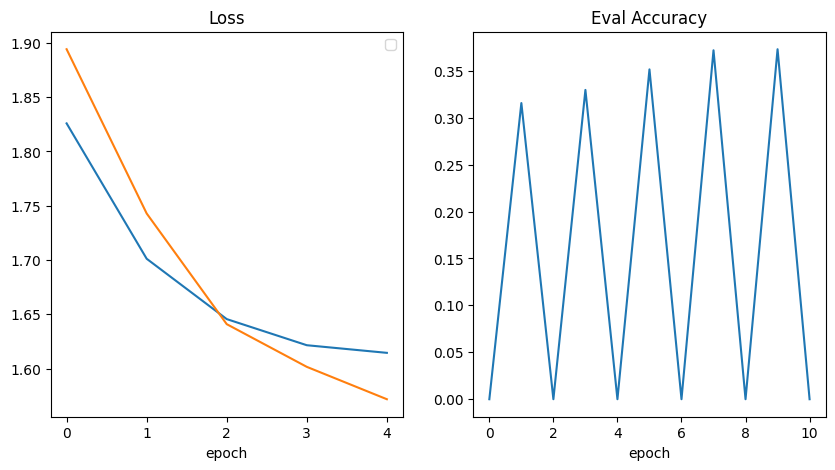

In [58]:
plot_graph()

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
import copy

def train_transformer(transformer_model, dataset, freeze_backbone=True):
    model = copy.copy(transformer_model)
       ### YOUR CODE IS HERE

    if freeze_backbone:
        freeze_backbone_function(model)

    metric_accuracy = evaluate.load("accuracy")

# Параметры обучения


    training_args = TrainingArguments(
        output_dir="./results",  # Каталог для сохранения результатов обучения
        num_train_epochs=10,  # Количество эпох обучения
        per_device_train_batch_size=8,  # Размер батча для обучения
        per_device_eval_batch_size=8,  # Размер батча для валидации
        warmup_steps=500,  # Количество шагов разогрева
        weight_decay=0.01,  # Сила L2 регуляризации
        logging_dir="./runs",  # Каталог для логов TensorBoard
        logging_steps=500,  # Логирование каждые 500 шагов
        evaluation_strategy="epoch",  # Стратегия оценки
        save_strategy="epoch",  # Стратегия сохранения модели
        load_best_model_at_end=True,  # Загрузка лучшей модели в конце
        metric_for_best_model="accuracy",  # Метрика для выбора лучшей модели
        greater_is_better=True,  # Указывает, что большее значение метрики лучше
        remove_unused_columns=False,
    )

    # Функция для вычисления метрик
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        # f1 = metric_f1.compute(predictions=predictions, references=labels, average='macro')
        acc = metric_accuracy.compute(predictions=predictions, references=labels)
        return acc

    trainer = Trainer(
        model=model,  # Модель для обучения
        args=training_args,  # Аргументы обучения
        train_dataset=dataset["train"],  # Набор данных для обучения
        eval_dataset=dataset["test"],  # Набор данных для валидации
        compute_metrics=compute_metrics,  # Метрики для вычисления
    )

    trainer.train()

    res = pd.DataFrame(trainer.state.log_history)
    res = res.fillna(0)

    return model, res 

In [ ]:
def plot_graph(e_loss, e_acc):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(e_loss)), e_loss)
    plt.title('Eval Loss')
    plt.xlabel("epoch")

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(e_acc)), e_acc, t_loss)
    plt.title('Eval Accuracy')
    plt.xlabel("epoch")

    plt.show()
    
def result(res):
    e_loss = []
    e_acc = []
    t_loss = []

    for el in res['eval_loss'].values:
        if el != 0:
            e_loss.append(el)
    for el in res['eval_accuracy'].values:
        if el != 0:
            e_acc.append(el)
    for el in res['loss'].values:
        if el != 0:
            t_loss.append(el)
    plot_graph(e_loss, e_acc)

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
rubert_tiny_transformer_model = TransformerClassificationModel(model_rubert_tiny2)
rubert_tiny_finetuned_with_freezed_backbone, history = train_transformer(rubert_tiny_transformer_model, dataset, freeze_backbone=True)
result(history)

rubert_tiny_transformer_model = TransformerClassificationModel(model_rubert_tiny2)
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model, dataset, freeze_backbone=False)
result(history)

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [111]:
full_dataset = load_dataset('csv', data_files='/kaggle/input/cleared-tasks/df_cleared0.csv')
# Фильтрация записей, в которых текстовые поля или метки не являются None
full_dataset = full_dataset.filter(lambda example: example['text'] is not None and example['labels'] is not None)

full_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 5209
    })
})

In [112]:
full_dataset['train'][0]

{'text': 'между девятью планетами солнечной системы введено космическое сообщение ракеты летают по следующим маршрутам земля меркурий плутон венера земля плутон плутон меркурий меркурий венера уран нептун нептун сатурн сатурн юпитер юпитер марс и марс уран можно ли добраться с земли до марса ',
 'labels': 1}

In [113]:
### YOUR CODE IS HERE (probably, similar on the previous step)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
mathbert = 'tbs17/MathBERT'
math_tokenizer = AutoTokenizer.from_pretrained(mathbert)
math_model = AutoModelForSequenceClassification.from_pretrained(mathbert, num_labels=7)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
math_dataset = full_dataset['train'].train_test_split(test_size=0.2)
math_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4167
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1042
    })
})

In [115]:
# math_dataset = full_dataset['train'].train_test_split(test_size=0.2)
math_dataset = math_dataset.map(lambda e:
                      math_tokenizer(e['text'],
                                truncation = True,
                                max_length=128,
                                padding='max_length'), batched=True)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

Map:   0%|          | 0/4167 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

Map:   0%|          | 0/1042 [00:00<?, ? examples/s]

In [116]:
math_dataset = math_dataset.remove_columns('text')
math_dataset = math_dataset.remove_columns('token_type_ids')
math_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4167
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1042
    })
})

In [11]:
# math_dataset['train'][10]

In [117]:
math_dataset.set_format(type='torch')

In [120]:
m_model = TransformerClassificationModel(math_model)
m_model.to(device)

TransformerClassificationModel(
  (backbone): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768

In [121]:
outputs = m_model(math_dataset['train']['input_ids'][0].unsqueeze(0).to(device), math_dataset['train']['attention_mask'][0].unsqueeze(0).to(device), math_dataset['train']['labels'][0].unsqueeze(0).to(device))
outputs

SequenceClassifierOutput(loss=tensor(1.7372, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.1990,  0.1233,  0.4281, -0.5320, -0.1089,  0.0055,  0.3089]],
       device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


[0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881]


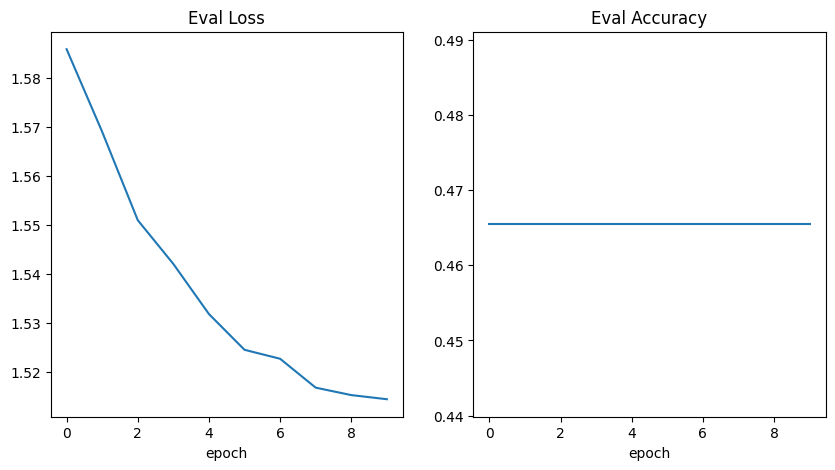

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


[0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881, 0.4654510556621881]


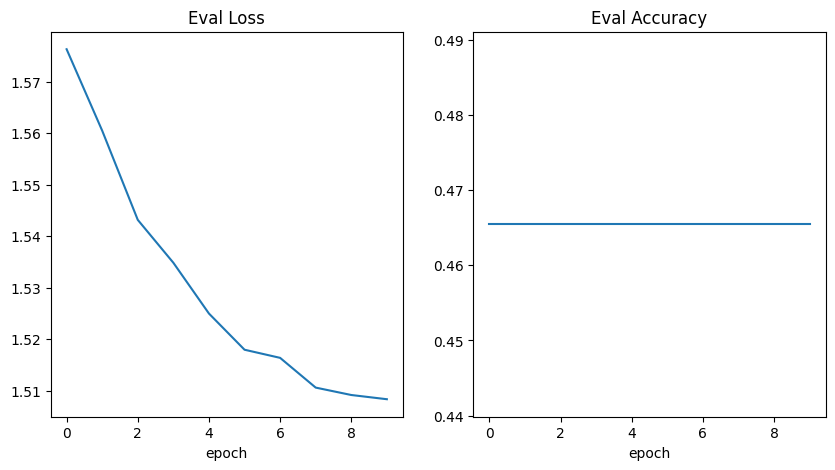

In [122]:
# math_transformer_model = TransformerClassificationModel(m_model)
math_finetuned_with_freezed_backbone = train_transformer(m_model, math_dataset, freeze_backbone=True)
result(math_finetuned_with_freezed_backbone)

# math_transformer_model = TransformerClassificationModel(m_model)
math_full_finetuned = train_transformer(m_model, math_dataset, freeze_backbone=False)
result(math_full_finetuned)

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
def draw_first_layer_attention_maps(attention_head_ids: List, text: str, model: TransformerClassificationModel):
    pass

In [167]:
def draw_attention(tokenizer, text, model):
    inputs = tokenizer(text, return_tensors="pt")
    model.eval().cpu()
    model.backbone.config.output_attentions = True

    with torch.no_grad():
        outputs = model.backbone(**inputs)
    attentions = outputs[-1]
    first_layer_attentions = attentions[0]


    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    num_heads = first_layer_attentions.size(1)
    for head_id in  range(num_heads):
        attention = first_layer_attentions[0, head_id].detach().numpy()

        plt.figure(figsize=(8, 8))
        sns.heatmap(attention, annot=False, cmap=sns.cubehelix_palette(as_cmap=True),xticklabels=tokens, yticklabels=tokens)
        plt.title(f"Layer 1 - Head {head_id} Attention Map")
        plt.xlabel("Tokens x")
        plt.ylabel("Tokens y")
        plt.show()

    model.backbone.config.output_attentions = False

In [170]:
rubert_tiny_transformer_model = TransformerClassificationModel(model_rubert_tiny2)
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model, dataset, freeze_backbone=True)
# result(rubert_tiny_finetuned_with_freezed_backbone)

rubert_tiny_transformer_model = TransformerClassificationModel(model_rubert_tiny2)
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model, dataset, freeze_backbone=False)
# result(rubert_tiny_full_finetuned)

loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0   1.4107   0.956673       0.000050   0.96   500   0.000000       0.000000   
1   0.0000   0.000000       0.000000   1.00   521   1.451439       0.469290   
2   1.4043   0.775295       0.000045   1.92  1000   0.000000       0.000000   
3   0.0000   0.000000       0.000000   2.00  1042   1.435175       0.479846   
4   1.3847   0.848117       0.000039   2.88  1500   0.000000       0.000000   
5   0.0000   0.000000       0.000000   3.00  1563   1.421823       0.484645   
6   1.3831   0.679815       0.000034   3.84  2000   0.000000       0.000000   
7   0.0000   0.000000       0.000000   4.00  2084   1.410891       0.490403   
8   1.3618   0.643182       0.000029   4.80  2500   0.000000       0.000000   
9   0.0000   0.000000       0.000000   5.00  2605   1.402443       0.498081   
10  1.3585   0.784045       0.000023   5.76  3000   0.000000       0.000000   
11  0.0000   0.000000       0.000000   6.00  3126   1.395513       0.500000   
12  1.3625   0.731515       0.000018   6.72  3500   0.000000       0.000000   
13  0.0000   0.000000       0.000000   7.00  3647   1.390473       0.500960   
14  1.3491   0.903253       0.000013   7.68  4000   0.000000       0.000000   
15  0.0000   0.000000       0.000000   8.00  4168   1.386943       0.501919   
16  1.3398   0.762536       0.000008   8.64  4500   0.000000       0.000000   
17  0.0000   0.000000       0.000000   9.00  4689   1.384793       0.502879   
18  1.3529   0.748866       0.000002   9.60  5000   0.000000       0.000000   
19  0.0000   0.000000       0.000000  10.00  5210   1.384068       0.503839   
20  0.0000   0.000000       0.000000  10.00  5210   0.000000       0.000000   

    eval_runtime  eval_samples_per_second  eval_steps_per_second  \
0         0.0000                    0.000                  0.000   
1         0.6198                 1681.154                211.354   
2         0.0000                    0.000                  0.000   
3         0.6168                 1689.257                212.373   
4         0.0000                    0.000                  0.000   
5         0.6794                 1533.818                192.831   
6         0.0000                    0.000                  0.000   
7         0.6269                 1662.056                208.953   
8         0.0000                    0.000                  0.000   
9         0.6863                 1518.249                190.874   
10        0.0000                    0.000                  0.000   
11        0.6173                 1687.905                212.203   
12        0.0000                    0.000                  0.000   
13        0.6217                 1675.979                210.704   
14        0.0000                    0.000                  0.000   
15        0.6058                 1720.087                216.249   
16        0.0000                    0.000                  0.000   
17        0.6148                 1694.829                213.074   
18        0.0000                    0.000                  0.000   
19        0.6211                 1677.589                210.906   
20        0.0000                    0.000                  0.000   

    train_runtime  train_samples_per_second  train_steps_per_second  \
0          0.0000                     0.000                   0.000   
1          0.0000                     0.000                   0.000   
2          0.0000                     0.000                   0.000   
3          0.0000                     0.000                   0.000   
4          0.0000                     0.000                   0.000   
5          0.0000                     0.000                   0.000   
6          0.0000                     0.000                   0.000   
7          0.0000                     0.000                   0.000   
8          0.0000                     0.000                   0.000   
9          0.0000                     0.000                 

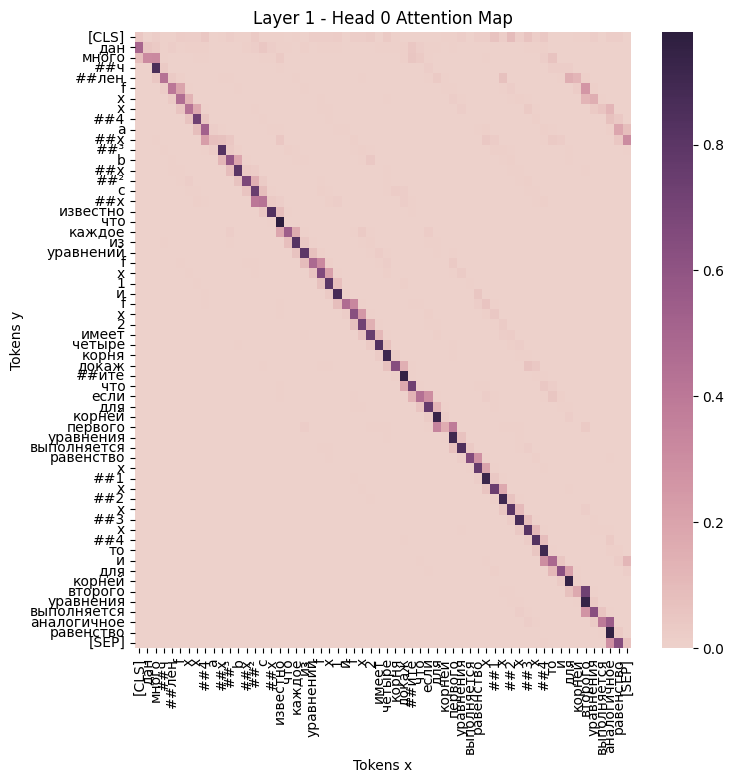

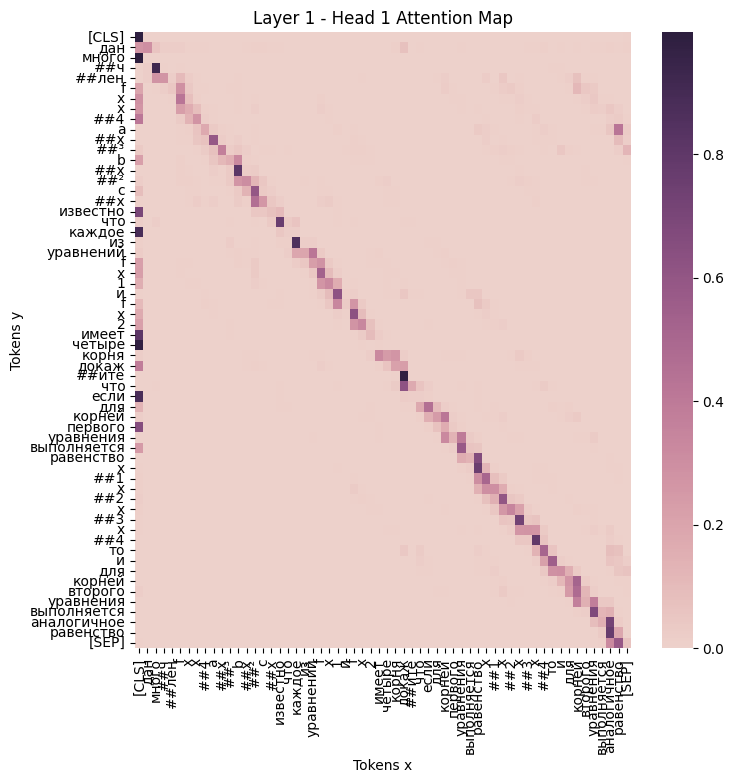

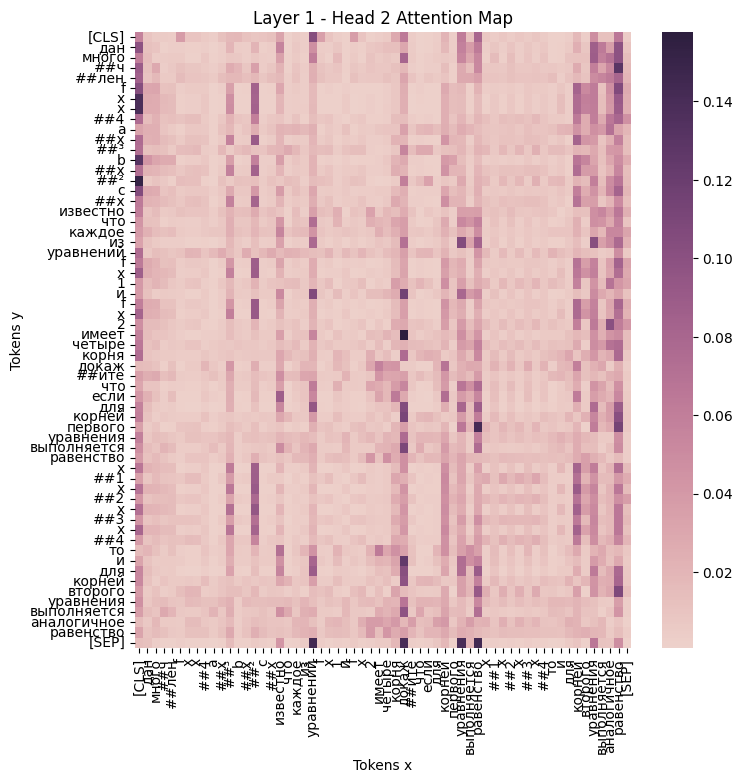

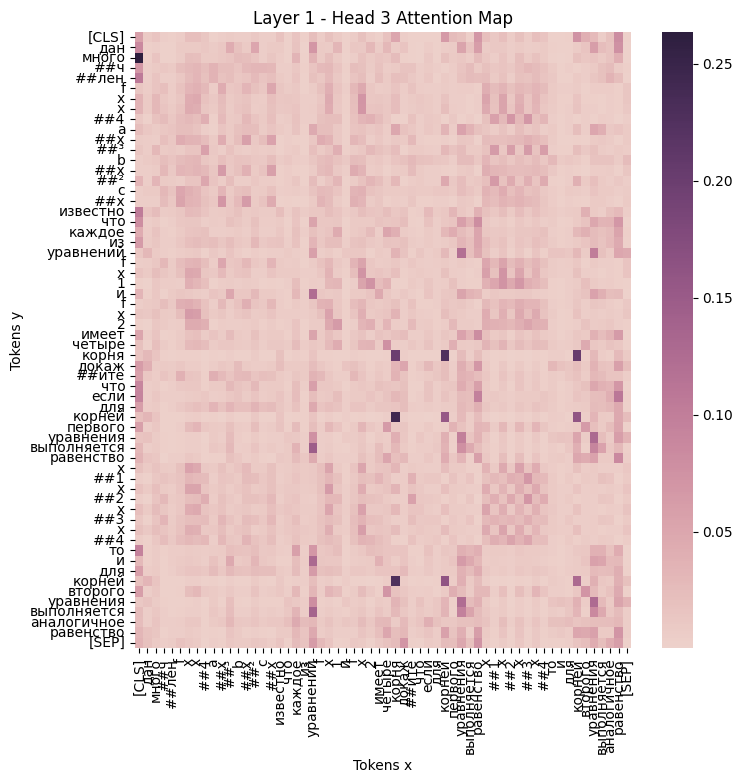

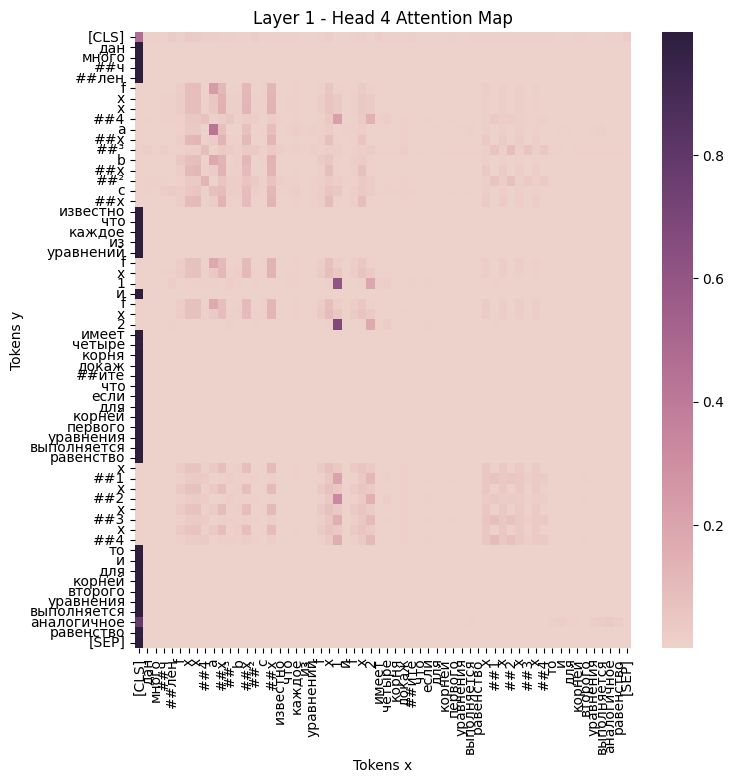

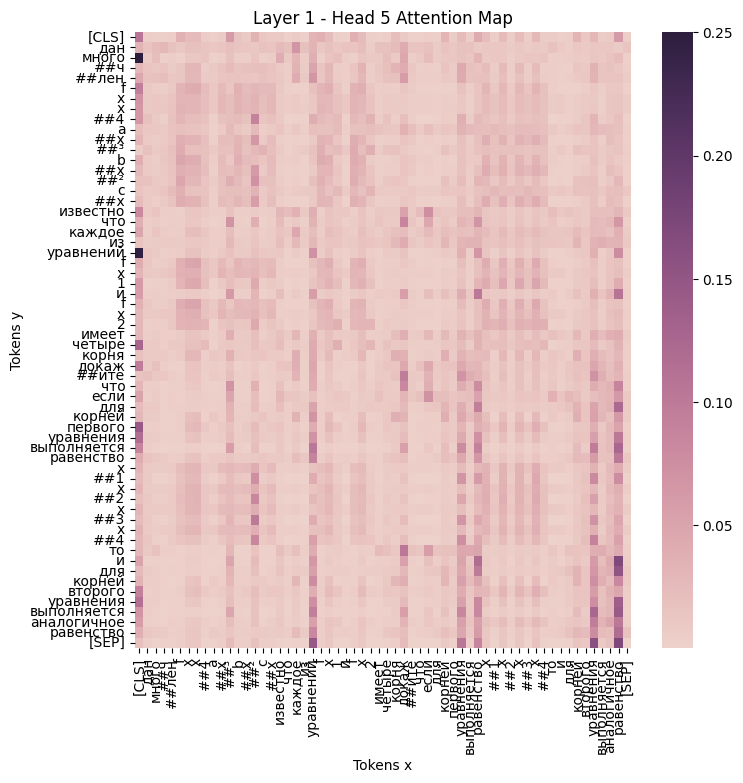

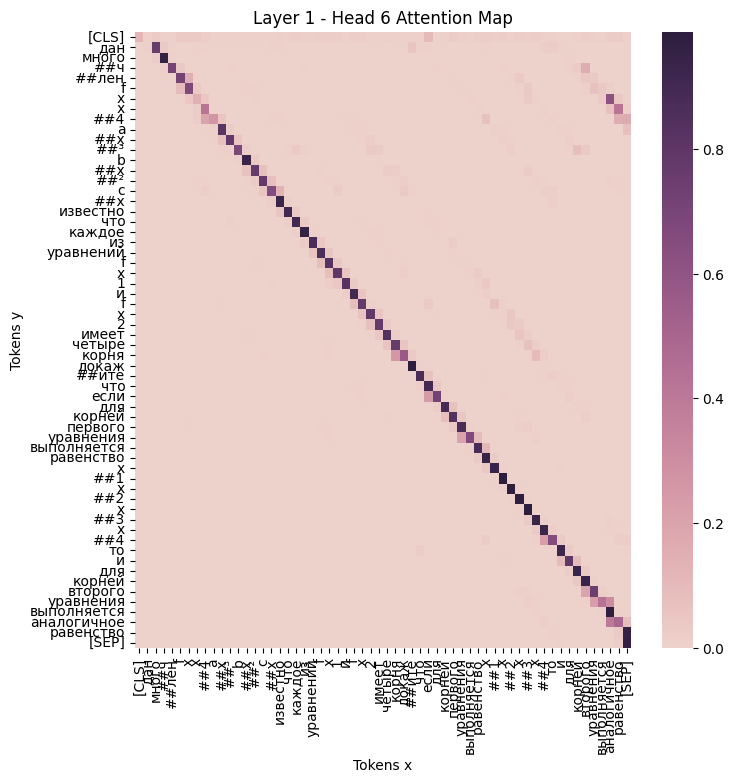

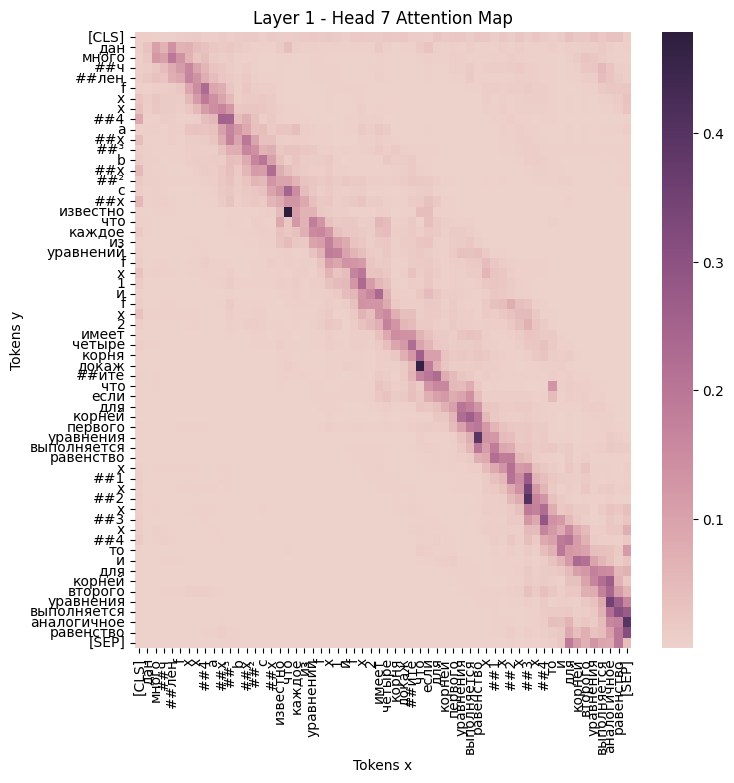

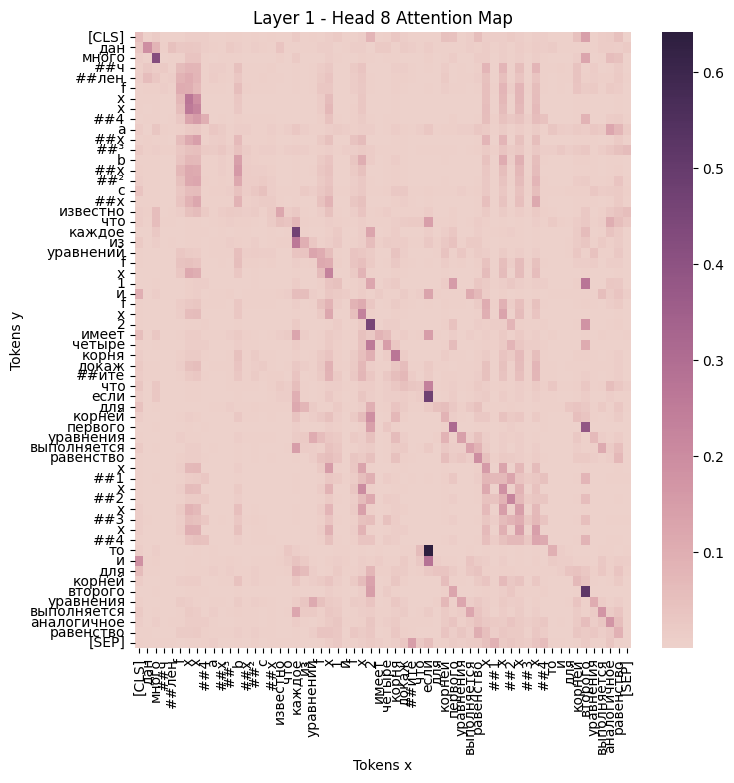

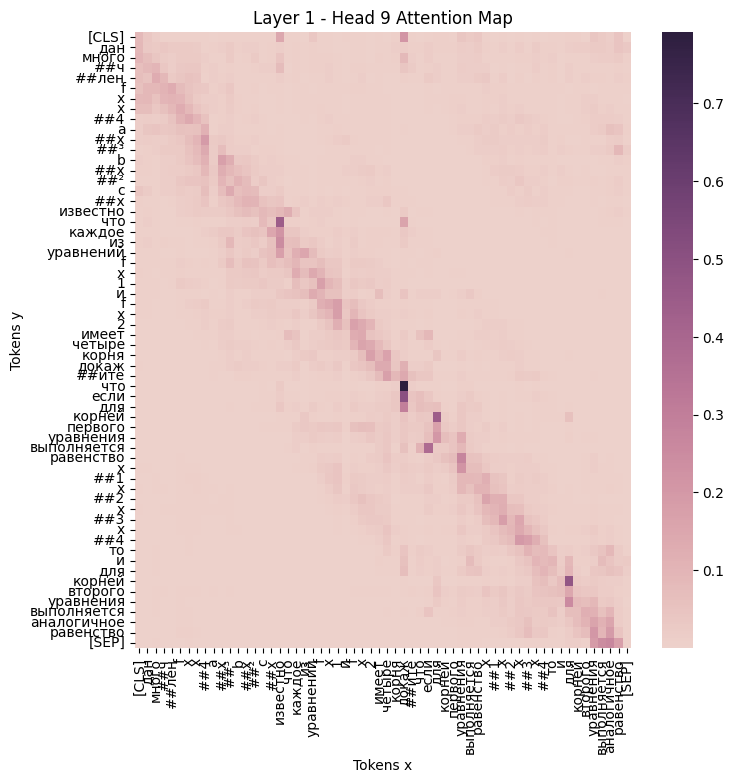

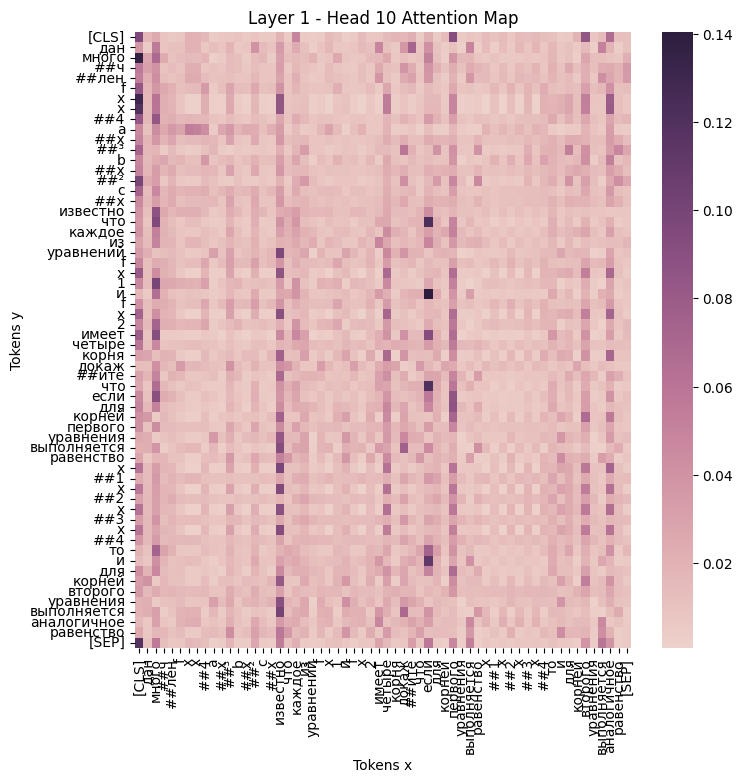

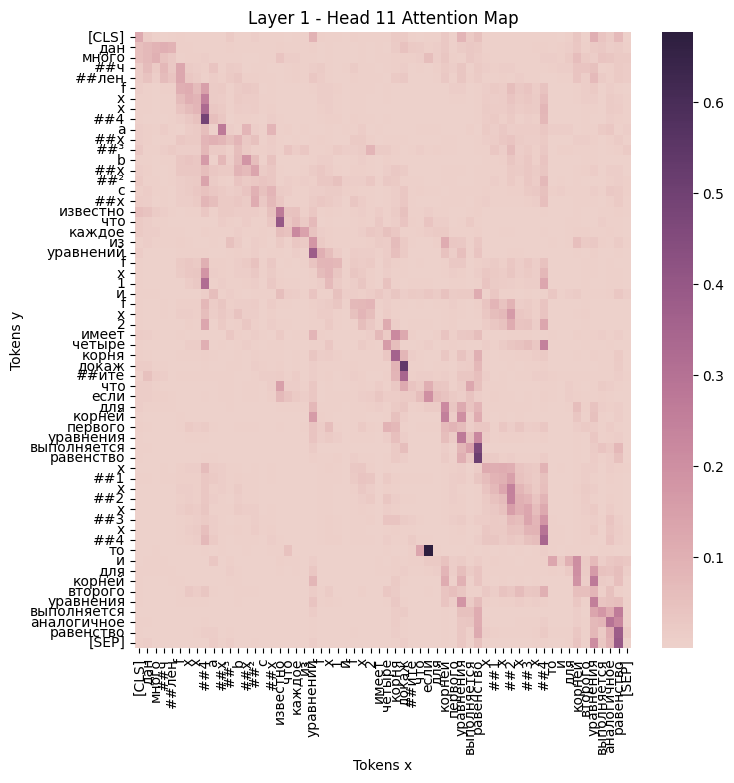

In [171]:
import random
sample = random.choice(full_dataset['train']['text'])
draw_attention(tokenizer, sample, rubert_tiny_transformer_model)

In [175]:
m_model

TransformerClassificationModel(
  (backbone): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768

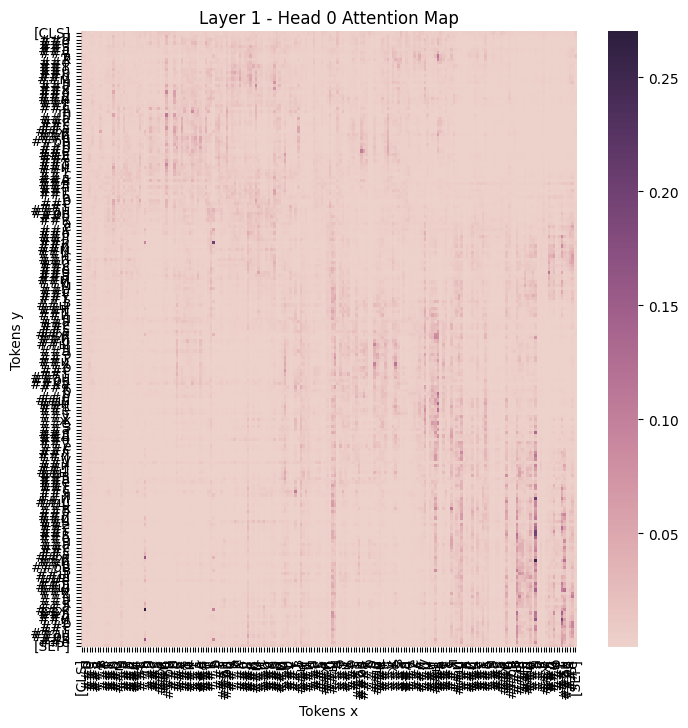

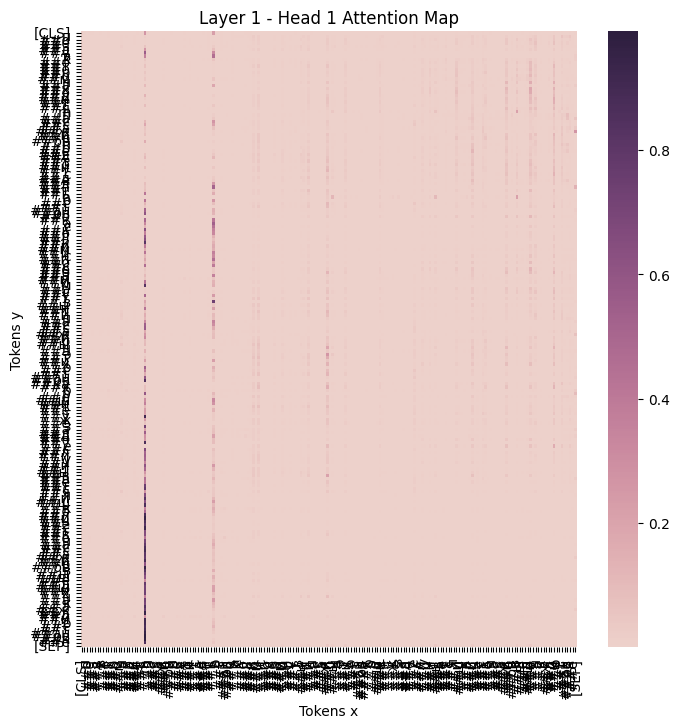

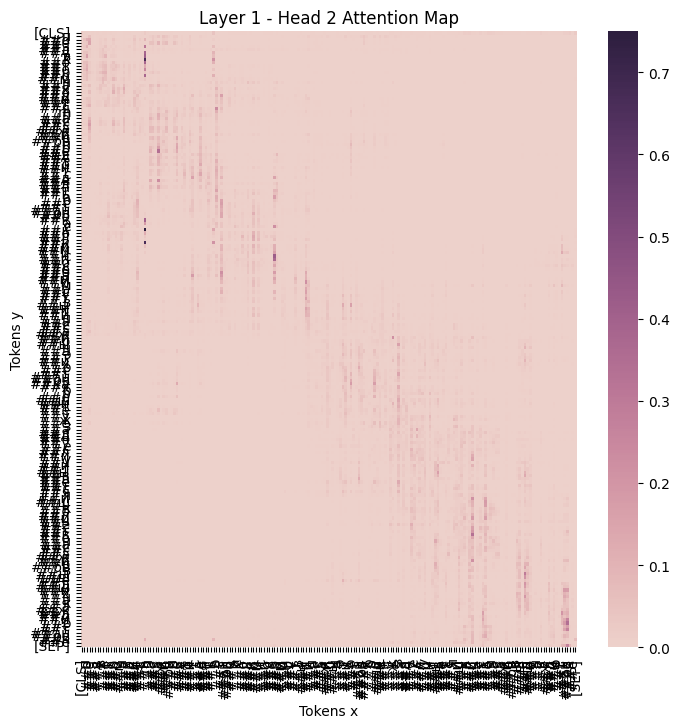

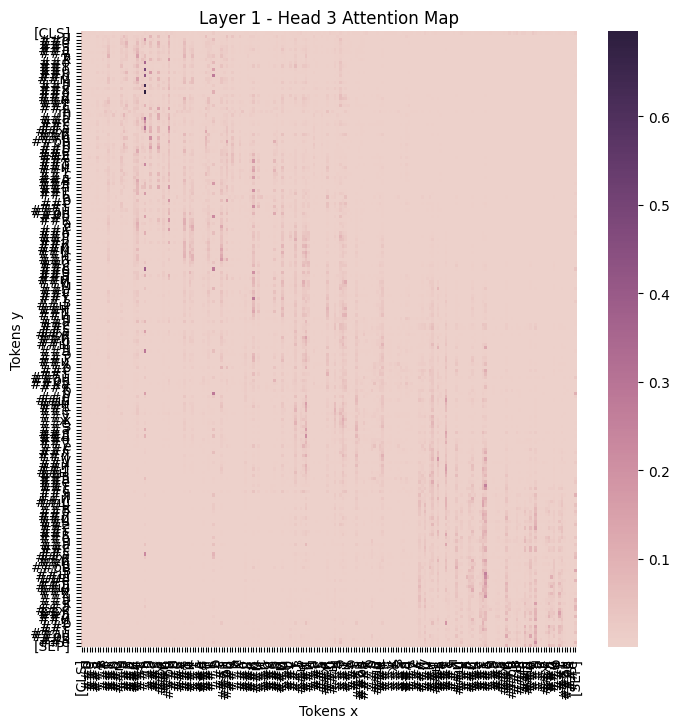

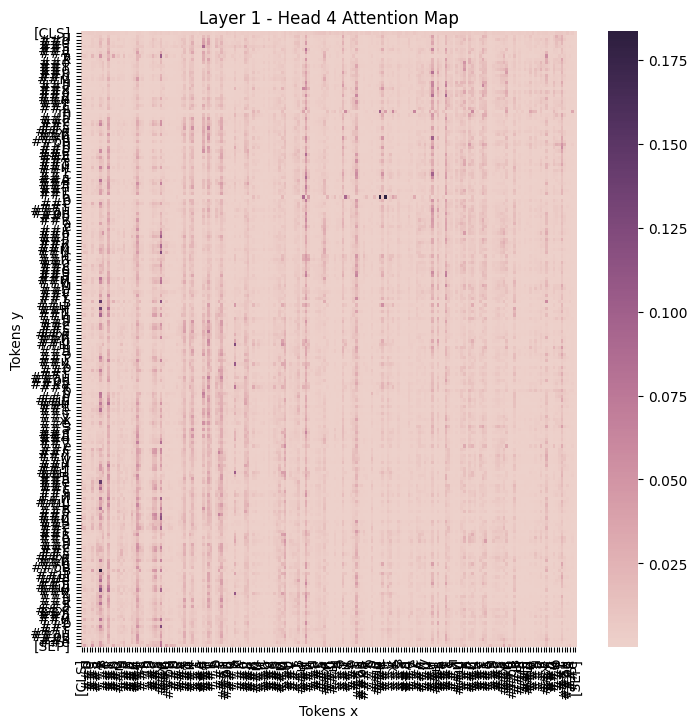

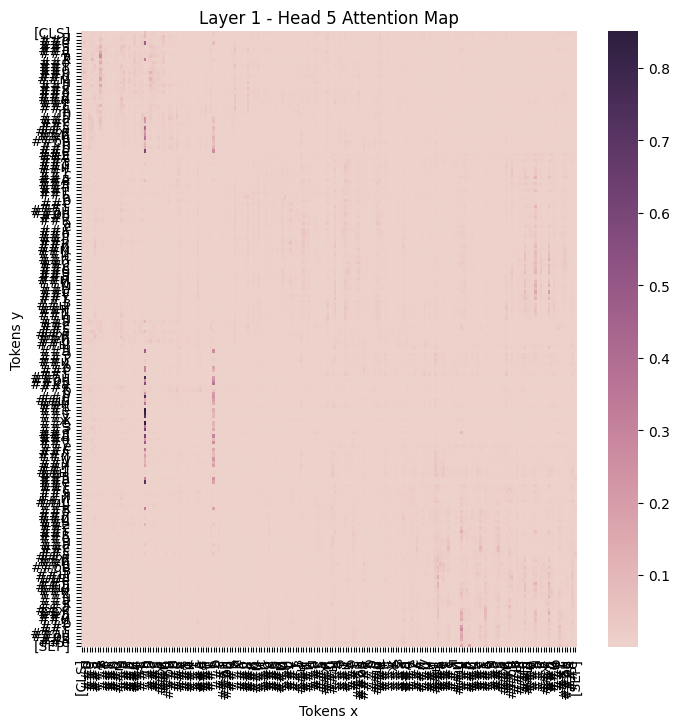

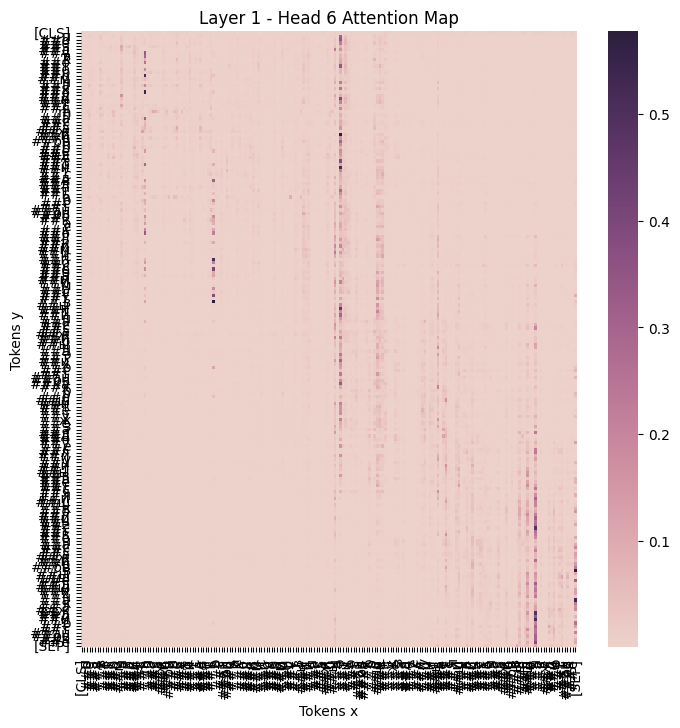

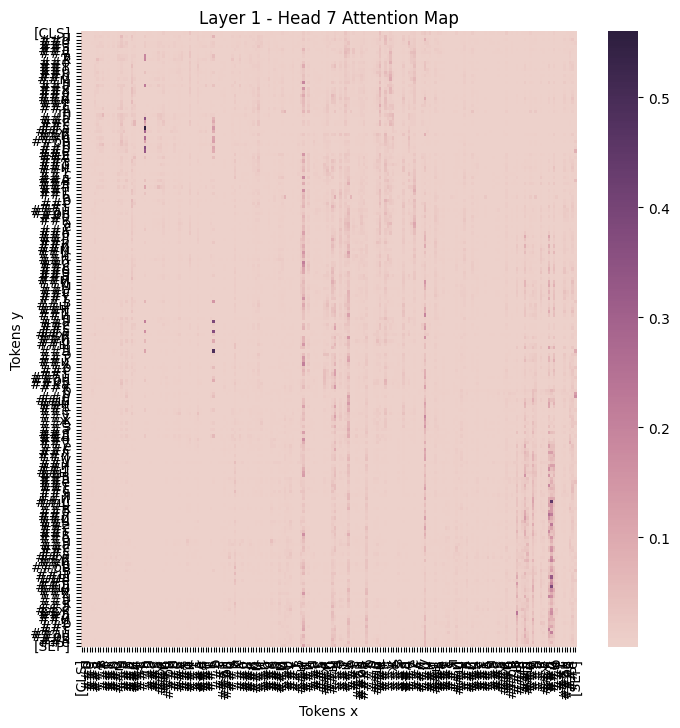

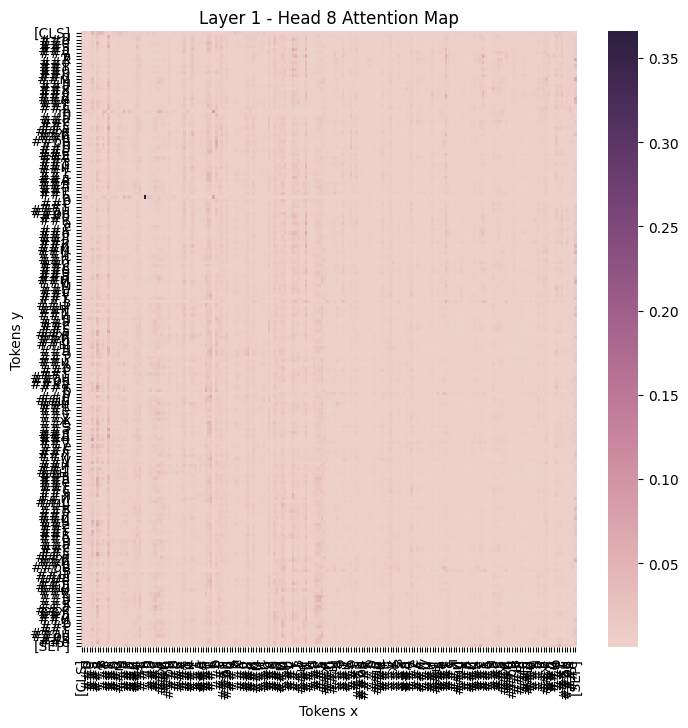

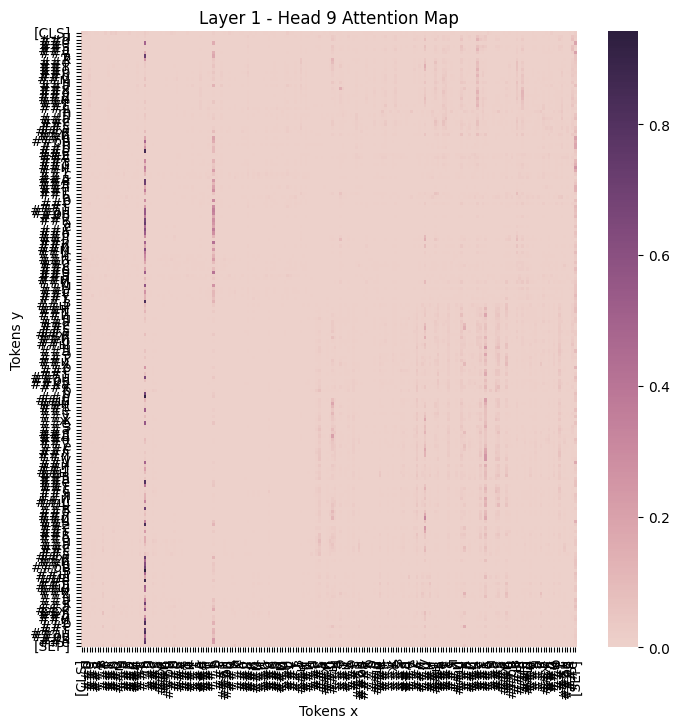

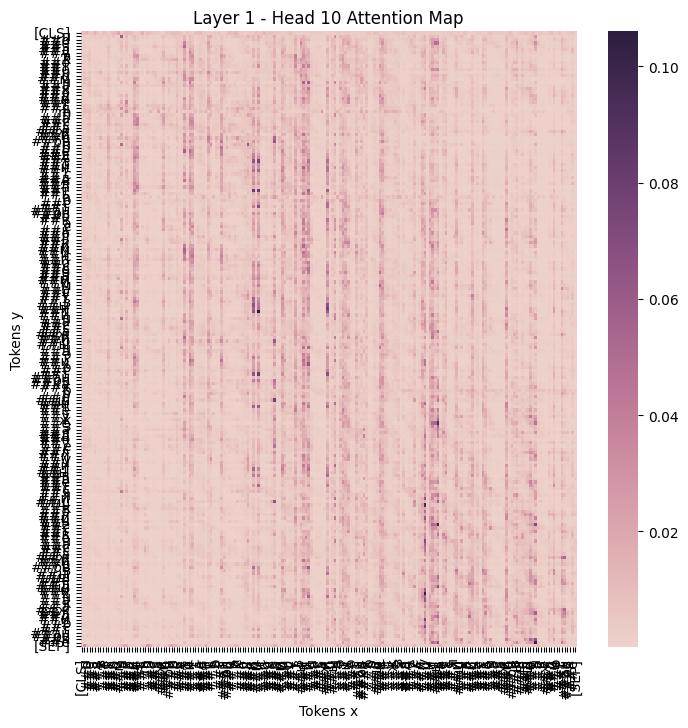

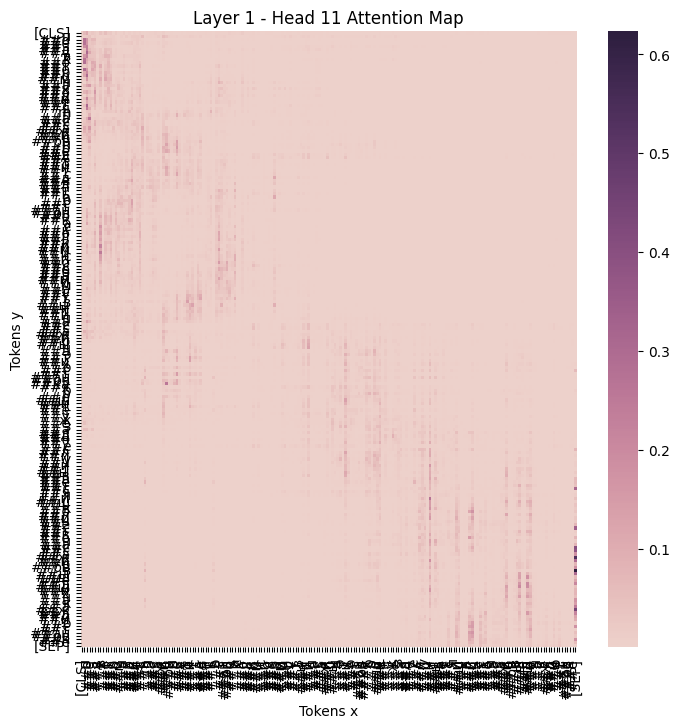

In [176]:
import random
sample = random.choice(full_dataset['train']['text'])
draw_attention(math_tokenizer, sample, m_model)

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [ ]:
### YOUR CODE IS HERE
math_finetuned_with_freezed_backbone = train_transformer(m_model, math_dataset, freeze_backbone=True)
result(math_finetuned_with_freezed_backbone)

# math_transformer_model = TransformerClassificationModel(m_model)
math_full_finetuned = train_transformer(m_model, math_dataset, freeze_backbone=False)
result(math_full_finetuned)

In [172]:
draw_attention(tokenizer, sample, math_finetuned_with_freezed_backbone)

TypeError: DataFrame.eval() missing 1 required positional argument: 'expr'

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

In [ ]:
### YOUR CODE IS HERE

